In [1]:
# Imports
import numpy as np
import kagglehub
import os
from PIL import Image
from matplotlib import pyplot as plt
import ipywidgets as widgets
from scipy.signal import convolve2d
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as T

In [2]:
dataset_path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset") + "/PetImages"

In [3]:
# Visualizar el directorio
os.listdir(dataset_path)
os.listdir(f"{dataset_path}/Cat")

['0.jpg',
 '1.jpg',
 '10.jpg',
 '100.jpg',
 '1000.jpg',
 '10000.jpg',
 '10001.jpg',
 '10002.jpg',
 '10003.jpg',
 '10004.jpg',
 '10005.jpg',
 '10006.jpg',
 '10007.jpg',
 '10008.jpg',
 '10009.jpg',
 '1001.jpg',
 '10010.jpg',
 '10011.jpg',
 '10012.jpg',
 '10013.jpg',
 '10014.jpg',
 '10015.jpg',
 '10016.jpg',
 '10017.jpg',
 '10018.jpg',
 '10019.jpg',
 '1002.jpg',
 '10020.jpg',
 '10021.jpg',
 '10022.jpg',
 '10023.jpg',
 '10024.jpg',
 '10025.jpg',
 '10026.jpg',
 '10027.jpg',
 '10028.jpg',
 '10029.jpg',
 '1003.jpg',
 '10030.jpg',
 '10031.jpg',
 '10032.jpg',
 '10033.jpg',
 '10034.jpg',
 '10035.jpg',
 '10036.jpg',
 '10037.jpg',
 '10038.jpg',
 '10039.jpg',
 '1004.jpg',
 '10040.jpg',
 '10041.jpg',
 '10042.jpg',
 '10043.jpg',
 '10044.jpg',
 '10045.jpg',
 '10046.jpg',
 '10047.jpg',
 '10048.jpg',
 '10049.jpg',
 '1005.jpg',
 '10050.jpg',
 '10051.jpg',
 '10052.jpg',
 '10053.jpg',
 '10054.jpg',
 '10055.jpg',
 '10056.jpg',
 '10057.jpg',
 '10058.jpg',
 '10059.jpg',
 '1006.jpg',
 '10060.jpg',
 '10061.jpg'

In [4]:
# Ver un par de imagenes
cat_images = os.listdir(f"{dataset_path}/Cat")

# Function to update image based on slider
def show_image(index):
    img_path = os.path.join(dataset_path, "Cat", cat_images[index])
    img = Image.open(img_path).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Slider widget
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(cat_images)-1,
    step=1,
)

# Link slider to function
widgets.interact(show_image, index=slider)

interactive(children=(IntSlider(value=0, description='index', max=12498), Output()), _dom_classes=('widget-int…

<function __main__.show_image(index)>

In [5]:
# Load them into a list(they'll be different sized)
MAX_IMAGES = 1500000

def load_images(path):
    images = os.listdir(path)
    images_loaded = []
    c = 0
    for img_name in images:
        img = Image.open(f"{path}/{img_name}").convert("L")
        # Crop it so it's centered and square
        width, height = img.size
        min_side = min(width, height)
        left = (width - min_side) // 2
        top = (height - min_side) // 2
        right = left + min_side
        bottom = top + min_side
        img = img.crop((left, top, right, bottom))
        # Resize to 128x128
        img = img.resize((64, 64))
        images_loaded.append(np.array(img))
        if c >= MAX_IMAGES:
            break
        c += 1

    return images_loaded

cat_images = load_images(f"{dataset_path}/Cat")
dog_images = load_images(f"{dataset_path}/Dog")

/home/pipev/Documents/Proyectos/SignTranslatorV2/.venv/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [6]:
# Convolution test
sobel_kernel_x = np.array([[-1,0,1],
                           [-2,0,2],
                           [-1,0,1]])
sobel_kernel_y = np.array([[1,2,1],
                           [0,0,0],
                           [-1,-2,-1]])
convolved_img = convolve2d(cat_images[1], sobel_kernel_y)

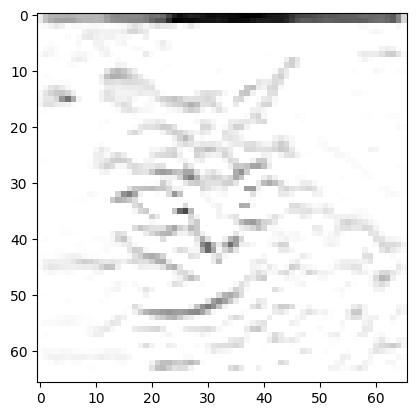

In [7]:
# Activation test
plt.imshow(1 - np.maximum(0, convolved_img), cmap="gray") # 1 - ... for inverting the image

In [8]:
# Prepare the data. Start by putting them on a 4D tensor (N, C, H, W)
X = np.array([[img] for img in cat_images] + [[img] for img in dog_images])
y = np.concatenate((np.zeros(len(cat_images)), np.ones(len(dog_images))))

# Normalize and convert them to float
X = X.astype(np.float32) / 255.0
y = y.astype(np.float32)

# Split in train, test  (test stays untouched)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y
)

# -------------------------
# Data augmentation (x2)
# -------------------------
# Ejemplo simple y determinístico: flip horizontal de TODAS las imágenes de train.
# X tiene forma (N, C, H, W); el eje de ancho es -1 (o 3).
X_train_flip = np.flip(X_train, axis=3).copy()  # copy() para memoria contigua
y_train_flip = y_train.copy()

# Concat: ahora el train queda duplicado
X_train = np.concatenate([X_train, X_train_flip], axis=0)
y_train = np.concatenate([y_train, y_train_flip], axis=0)

# Si preferís otra augmentación (rotación 90°), podés usar:
# X_train_rot = np.stack([np.rot90(x, k=1, axes=(1,2)) for x in X_train_orig], axis=0).astype(np.float32)

# Create torch's DataLoader for batching
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
    batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)),
    batch_size=128, shuffle=False
)

In [9]:
print(X_train.shape)

(39996, 1, 64, 64)


In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layer
        # The two numbers are the Cout and Cin numbers
        self.conv_y = nn.Conv2d(1, 1, kernel_size=3, padding="same", bias=True)
        self.conv_x = nn.Conv2d(1, 1, kernel_size=3, padding="same", bias=True)
        sobel_y = torch.tensor([
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1],
        ], dtype=torch.float32)
        sobel_x = torch.tensor([
            [1, 2, 1],
            [0, 0, 0],
            [-1, -2, -1],
        ], dtype=torch.float32)
        # The unsqueeze adds a dimension(at index 0) so the weights have a 4D tensor shape
        self.conv_y.weight = nn.Parameter(sobel_y.unsqueeze(0).unsqueeze(0), requires_grad=False)
        self.conv_x.weight = nn.Parameter(sobel_x.unsqueeze(0).unsqueeze(0), requires_grad=False)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Square of area 2 for the pooling

        # Feature extraction
        self.fc0 = nn.Conv2d(1, 1, kernel_size=3, padding="same", bias=True)
        self.fc1 = nn.Conv2d(1, 1, kernel_size=3, padding="same", bias=True)

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(1024, 256), # 1/4 of features
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Convol layers
        feature_0_0 = self.pool(self.conv_y(x))
        feature_1_0 = self.pool(self.conv_x(x))
        # Feature extraction
        feature_0_1 = self.pool(self.fc0(feature_0_0))
        feature_1_1 = self.pool(self.fc1(feature_0_0))
        feature_2_1 = self.pool(self.fc0(feature_1_0))
        feature_3_1 = self.pool(self.fc1(feature_1_0))
        # Concat and flatten
        out = torch.cat([feature_0_1, feature_1_1, feature_2_1, feature_3_1], axis=1) # Axis 0 is the batch, 1 is the axis, 2 is y, 3 is x
        out = torch.flatten(out, 1) # Flatten along the first axis forwards
        # FC layers
        out = self.fc_layers(out)
        return out

In [11]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding="same", bias=True),
            nn.ReLU(),
            nn.MaxPool2d(4, 4),
            nn.Conv2d(16, 32, kernel_size=3, padding="same", bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding="same", bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            # FC layers
            nn.Linear(64 * 4 * 4, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [12]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Train the model
model = SmallCNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

EPOCH = 30
for epoch in range(EPOCH):
    model.train()
    epoch_loss = 0.0  # Track total loss for the epoch
    num_batches = 0
    
    for batch_images, batch_labels in train_loader:
        # Move batch to GPU
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        output = model(batch_images).squeeze(1)
        loss = criterion(output, batch_labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()  # Accumulate loss
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch}, Avg Loss: {avg_loss:.4f}")

Using device: cuda
Epoch 0, Avg Loss: 0.6925
Epoch 1, Avg Loss: 0.6884
Epoch 2, Avg Loss: 0.6749
Epoch 3, Avg Loss: 0.6585
Epoch 4, Avg Loss: 0.6325
Epoch 5, Avg Loss: 0.6087
Epoch 6, Avg Loss: 0.5785
Epoch 7, Avg Loss: 0.5506
Epoch 8, Avg Loss: 0.5259
Epoch 9, Avg Loss: 0.5009
Epoch 10, Avg Loss: 0.4853
Epoch 11, Avg Loss: 0.4668
Epoch 12, Avg Loss: 0.4533
Epoch 13, Avg Loss: 0.4341
Epoch 14, Avg Loss: 0.4246
Epoch 15, Avg Loss: 0.4118
Epoch 16, Avg Loss: 0.3926
Epoch 17, Avg Loss: 0.3803
Epoch 18, Avg Loss: 0.3713
Epoch 19, Avg Loss: 0.3565
Epoch 20, Avg Loss: 0.3451
Epoch 21, Avg Loss: 0.3316
Epoch 22, Avg Loss: 0.3202
Epoch 23, Avg Loss: 0.3102
Epoch 24, Avg Loss: 0.2984
Epoch 25, Avg Loss: 0.2908
Epoch 26, Avg Loss: 0.2805
Epoch 27, Avg Loss: 0.2684
Epoch 28, Avg Loss: 0.2589
Epoch 29, Avg Loss: 0.2467


In [13]:
# Evaluate on test set
model.eval()  # Set model to evaluation mode (disables dropout, etc.)
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for efficiency
    for batch_images, batch_labels in test_loader:
        # Move batch to GPU
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        # Get predictions
        outputs = model(batch_images).squeeze(1)
        predictions = (outputs > 0.5).float()  # Convert probabilities to binary predictions
        
        # Count correct predictions
        correct += (predictions == batch_labels).sum().item()
        total += batch_labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 84.46%


In [14]:
# Evaluate on train set
model.eval()  # Set model to evaluation mode (disables dropout, etc.)
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for efficiency
    for batch_images, batch_labels in train_loader:
        # Move batch to GPU
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        # Get predictions
        outputs = model(batch_images).squeeze(1)
        predictions = (outputs > 0.5).float()  # Convert probabilities to binary predictions
        
        # Count correct predictions
        correct += (predictions == batch_labels).sum().item()
        total += batch_labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 91.41%


In [15]:
import plotly.graph_objects as go
import copy


def get_model_params(model):
    params = []
    for param in model.parameters():
        if param.requires_grad:
            params.append(param.data.view(-1).cpu())
    return torch.cat(params)


def set_model_params(model, params):
    offset = 0
    for param in model.parameters():
        if param.requires_grad:
            param_size = param.numel()
            param.data.copy_(params[offset:offset + param_size].view(param.size()))
            offset += param_size


def generate_random_direction(params):
    random_direction = torch.randn_like(params)
    # Normalize the direction
    random_direction /= random_direction.norm()
    return random_direction


# Get base parameters and generate random directions
base_params = get_model_params(model)
direction1 = generate_random_direction(base_params)
direction2 = generate_random_direction(base_params)

In [16]:
# Create grid and compute loss values
grid_size = 100
alpha_range = torch.linspace(-100, 100, grid_size)
loss_surface = torch.zeros((grid_size, grid_size))

model.eval()
for i, alpha in enumerate(alpha_range):
    for j, beta in enumerate(alpha_range):
        # Create a copy of the model
        temp_model = copy.deepcopy(model)

        # Update parameters
        new_params = base_params + alpha * direction1 + beta * direction2
        set_model_params(temp_model, new_params)

        # Compute loss
        temp_model = temp_model.to(device)
        total_loss = 0
        points_used = 0

        with torch.no_grad():
            for batch_images, batch_labels in test_loader:
                if points_used >= 20:
                    break
                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)
                outputs = temp_model(batch_images).squeeze(1)
                loss = criterion(outputs, batch_labels)
                total_loss += loss.item()
                points_used += len(batch_images)

        loss_surface[i, j] = total_loss / (points_used / batch_images.size(0))
        del temp_model


In [19]:
# Create 3D plot
X, Y = np.meshgrid(alpha_range.numpy(), alpha_range.numpy())

fig = go.Figure()
# Add surface plot
fig.add_trace(go.Surface(x=X, y=Y, z=loss_surface.numpy()))
# Add dot at origin (model params)
fig.add_trace(go.Scatter3d(x=[0], y=[0], z=[loss_surface[grid_size // 2, grid_size // 2].numpy()],
                           mode='markers',
                           marker=dict(size=8, color='red'),
                           name='Model Parameters'))

fig.update_layout(
    title='Loss Landscape',
    scene=dict(
        xaxis_title='Direction 1',
        yaxis_title='Direction 2',
        zaxis_title='Loss'
    ),
    width=800,
    height=800
)
fig.show()


In [44]:
from loss_landscape import compute_and_plot_loss_surface

loss_surface = compute_and_plot_loss_surface(
    model=model,
    test_loader=test_loader,
    criterion=torch.nn.BCEWithLogitsLoss(),
    direction1=direction1,
    direction2=direction2,
    grid_size=100,
    range_limit=1e3,
    show_plot=True
)